In [1]:
from Preprocessing_Module import read_data, add_topological, add_landcover, merge_new_data, fill_data, select_columns, reshape_dataset, fillna_dataset, remove_nan_features, unused_stations
from Feature_Expansion_Module import feature_expansion
from Initializer_Module import initializer
from XGboost_Model_Module import Xgboost_model
from Neural_Network_Module import FeedforwardNeuralNetModel
from Model_Validation_Module import give_predictions_nn, evaluate_nn, give_predictions_xgboost, evaluate_xgboost, validate_results, merge_predictions
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [ ]:
# original backup cell from Argyro
# Run the Next

data = read_data('../Datasets/Greece/GRE_culex_2011_2023.csv')
data = merge_new_data('../Datasets/Greece/monthly_data/GRE_culex_ento_2024_09_processed.csv', data)
data = merge_new_data('../Datasets/Greece/monthly_data/GRE_env_2024_10_2km_processed.csv', data)
#=====================================================================
data = data[(data.nuts2_name == 'CENTRAL MACEDONIA') | (data.nuts2_name == 'Π. ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ')] 
data = data.reset_index(drop=True)
#=====================================================================
columns = ['dt_placement', 'x', 'y', 'culex spp.', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/greece_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/greece_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

In [3]:
data = read_data('../Datasets/Greece/GRE_culex_2011_2024.csv')
#data = merge_new_data('../Datasets/Greece/monthly_data/GRE_culex_ento_2024_09_processed.csv', data)
data = merge_new_data('../Datasets/Greece/monthly_data/GRE_env_2025_05_2km_processed.csv', data)
#=====================================================================
data = data[(data.nuts2_name == 'CENTRAL MACEDONIA') | (data.nuts2_name == 'Π. ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ')] 
data = data.reset_index(drop=True)
#=====================================================================
columns = ['dt_placement', 'x', 'y', 'culex spp.', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/greece_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/greece_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['trap_id', 'station_id', 'x', 'y', 'dt_placement', 'week', 'month',
       'year', 'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code',
       'nuts1_name', 'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex spp.',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_m

In [4]:
data

,x,y,dt_placement,mosq_now,key_0,ndvi,ndwi,ndmi,ndbi,ndvi_mean,...,lst_apr_night_mean,DISTANCE_TO_COAST,DISTANCE_TO_RIVER,SLOPE_mean_1km,ASPECT_mean_200m,ELEVATION_mean_1km,HILLSHADE_mean_1km,FS_AREA_1km,FLOW_ACCU_200m,landcover
0,21.715938,40.833181,2025-05-01,NaN,12654,0.322758,-0.386633,-0.124217,0.124217,0.227572,...,13875.250000,6747.715614,4227.503800,9,308.161727,1381.733579,190.541782,0.000000,2.774426,9
1,21.715938,40.851148,2025-05-01,NaN,12751,0.519589,-0.468197,0.093851,-0.093851,0.497812,...,13871.222222,8037.848903,3805.567092,21,215.256304,1541.866563,203.764415,0.000000,1.552265,9
2,21.715938,40.869115,2025-05-01,NaN,12849,0.435929,-0.382327,0.147700,-0.147700,0.490804,...,13907.111111,9392.939779,1810.433627,21,237.383863,1505.883282,214.545056,0.000000,2.673370,1
3,21.739361,40.779281,2025-05-01,NaN,12470,0.316938,-0.308981,-0.110489,0.110489,0.344096,...,14021.333333,2653.361404,2455.520450,3,173.274553,904.683727,184.870832,0.000000,1.000000,10
4,21.739361,40.797248,2025-05-01,NaN,12562,0.334244,-0.332424,-0.146653,0.146653,0.407938,...,14036.222222,3355.116621,2299.673310,5,190.680806,902.481673,177.218633,0.000000,1.041934,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15057,24.386079,40.150447,2025-05-01,NaN,10375,0.616112,-0.479795,0.323200,-0.323200,0.601904,...,14139.250000,854.397735,7353.890315,13,84.366674,199.077555,150.063796,0.032912,5.233104,2
15058,24.386079,40.168414,2025-05-01,NaN,10411,0.466340,-0.399942,0.145863,-0.145863,0.371880,...,NaN,317.955925,5773.394919,10,83.921427,112.114131,150.963799,0.798918,22.416683,1
15059,24.386079,40.186381,2025-05-01,NaN,10450,-0.115000,0.303150,0.296703,-0.296703,-0.112008,...,NaN,0.000000,4532.269126,20,0.000000,15.070398,172.839159,2.432697,4.000000,17
15060,24.409501,40.132480,2025-05-01,NaN,10341,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,10127.798323,0,0.000000,0.000000,180.000000,3.125107,NaN,17


In [5]:
# set the date of prediction for the test set
date = '2025-05-01'

# set the filename for export
case = 'Culex_Greece_CM_'

# set the filename to export
path = './predictions/Greece/Central_Macedonia/'

# title = date[:-3].replace(date[:-3][-1],str(int(date[:-3][-1])+1)).replace('-','_')
title = date[:-3].replace('-','_')
title = case + title

# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'

In [6]:
data = feature_expansion(data)

In [7]:
data = initializer(data, model_type, 10)

Bounds: [    0.      4.     12.     24.     43.     71.    124.    208.    355.
   684.4 10458. ]


In [ ]:
print("#===========================================")
print("Performance of the previous month")
print("#===========================================")
print()
validate_results(path+case + date[:-3].replace(date[:-3].split('-')[1],str(int(date[:-3].split('-')[1])-1)).replace('-','_')+'.csv',data)

In [ ]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.4)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')
    
num_class = 1
hidden_layers = [264,128,128,64,32]
learning_rate = 0.001
epochs = 50
batch_size = 128
dropout = 0.2
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)

    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    
    model = FeedforwardNeuralNetModel(num_features=len(data_env.iloc[0,:])-2, num_class=num_class,
                                      hidden_layers = hidden_layers, model_type=model_type,
                                      learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                      dropout = dropout, embedding_data=embedded_data, 
                                      transformation_list=transformation_list, early_stop = early_stop, 
                                      l1_weight=0, l2_weight=0, weights=False)

    evaluate_nn(model, data_env, fi = fi)

    predictions_env = give_predictions_nn(model, data_env, test_env, env = True, filepath = path, case = title,
                                          export = only_env)

    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = FeedforwardNeuralNetModel(num_features=len(data_entom.iloc[0,:])-2, num_class=num_class,
                                          hidden_layers = hidden_layers, model_type=model_type,
                                          learning_rate = learning_rate, epochs = epochs, batch_size = batch_size,
                                          dropout = dropout, embedding_data=embedded_data, 
                                          transformation_list=transformation_list, early_stop = early_stop, 
                                          l1_weight=0, l2_weight=0, weights=False)
        
        evaluate_nn(model, data_entom, fi = fi)

        predictions_entom = give_predictions_nn(model, data_entom, test_entom, env = False, filepath = path,
                                                case = title, export = False)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom,path,title,export=True)

#===========================================
Predictions without entomological features
#===========================================



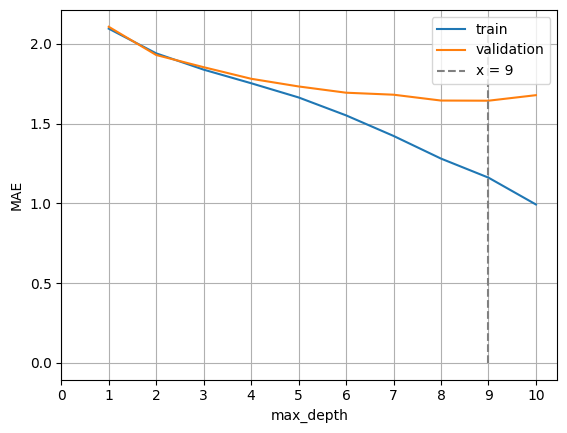

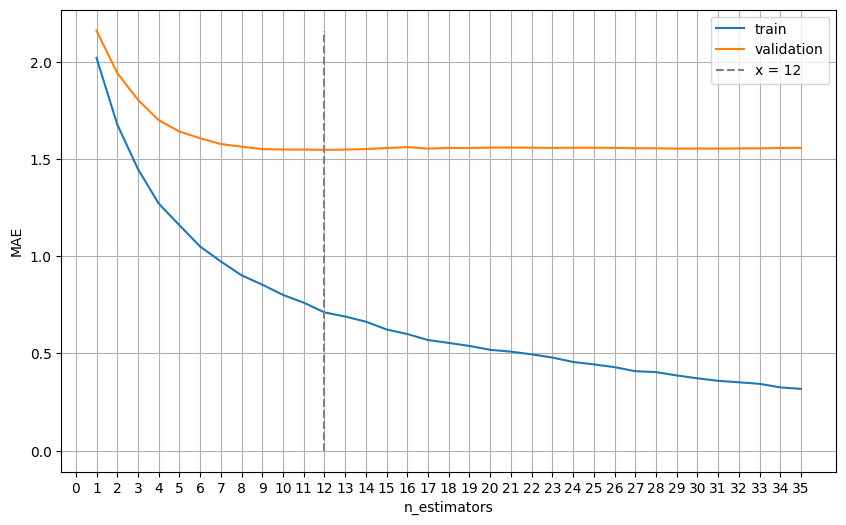

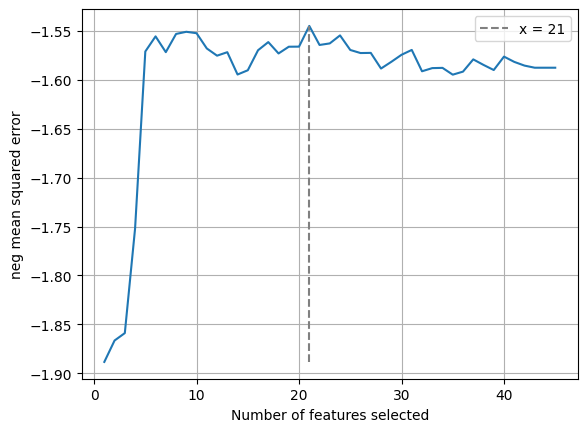

max_depth:  9
Number of estimators:  12
Selected_features:  Index(['lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
       'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean',
       'lst_apr_night_mean', 'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER',
       'SLOPE_mean_1km', 'ASPECT_mean_200m', 'ELEVATION_mean_1km',
       'HILLSHADE_mean_1km', 'FLOW_ACCU_200m', 'landcover',
       'null_island_distance', 'days_distance', 'mo_cos', 'year', 'lst',
       'summer_days_month'],
      dtype='object')
MAE on train set:  0.8030259365994237
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.609221902017291
Error <= 2: 79.60 %
min prediction: 0.0
max prediction: 9.0


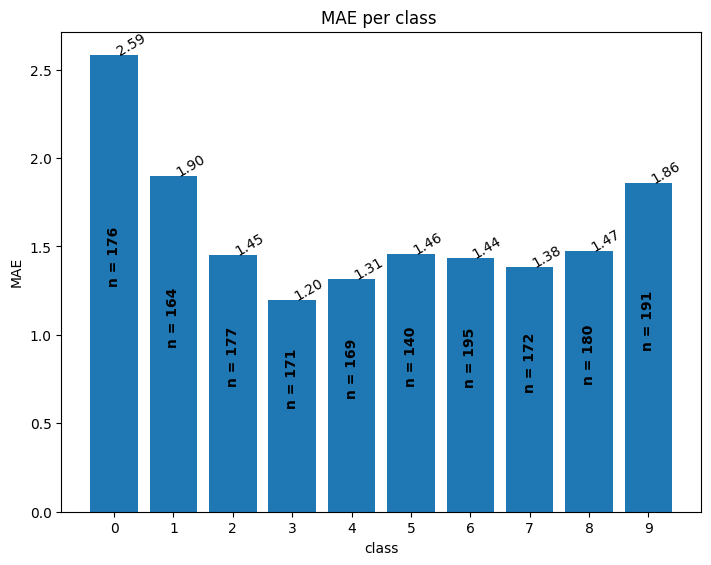

-----------|class error-MAE| difference-----------
mean: 0.40613617299820304
std: 0.22190937105289174
coefficient of variation (std/mean): 0.546391545019738

----------normalized difference-------------
mean: 0.5589630948416618
std: 0.30541270899955


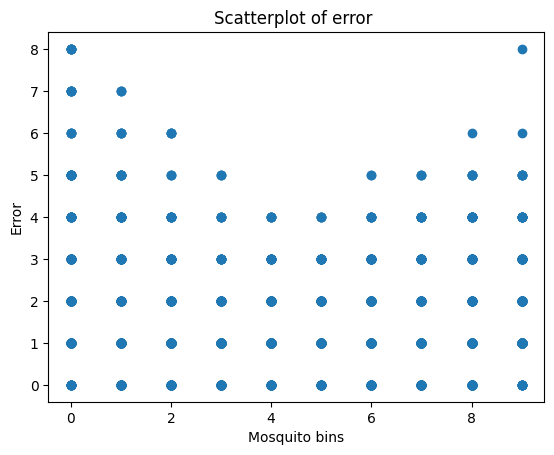

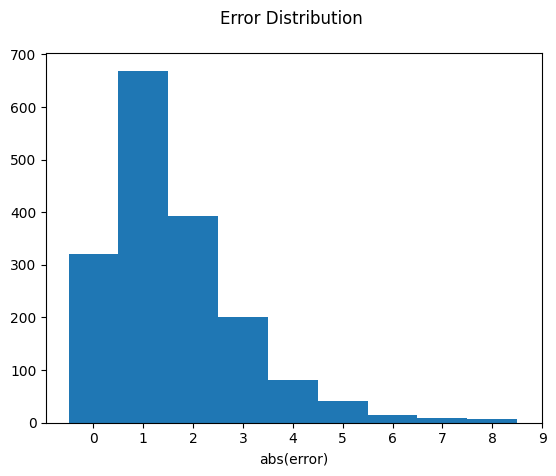

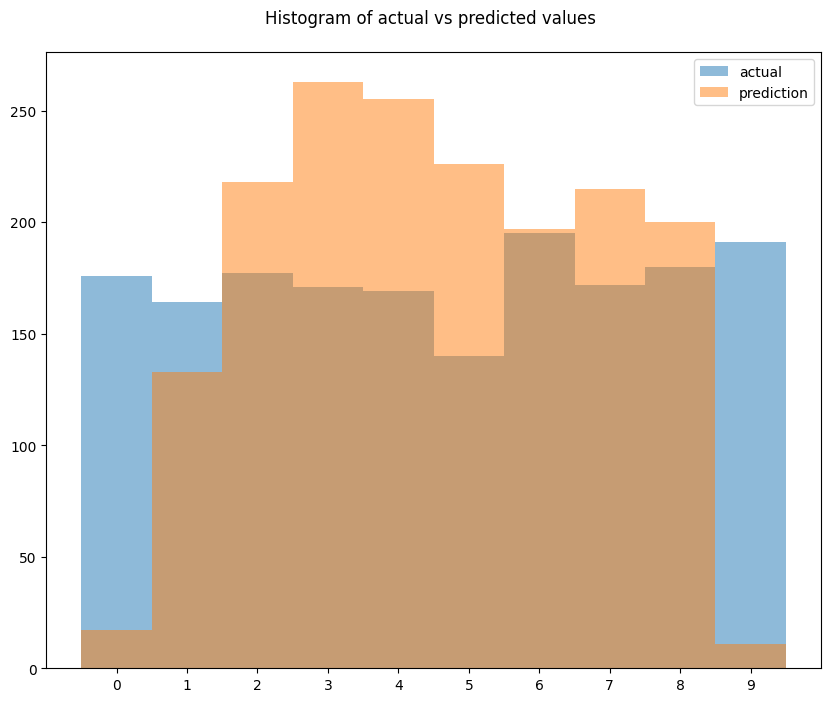

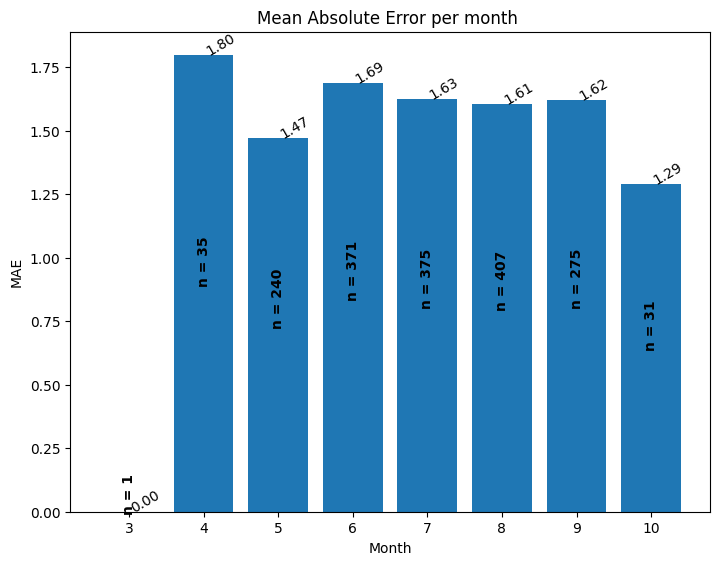

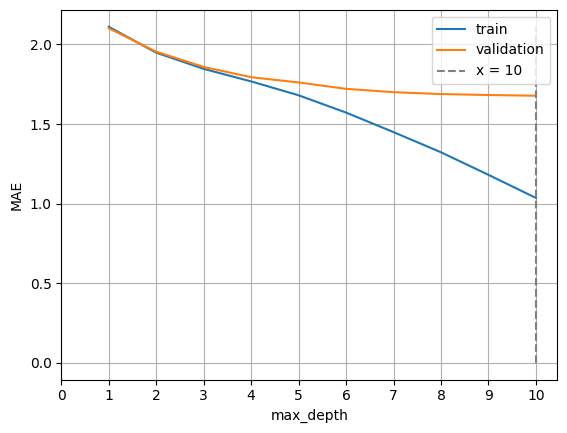

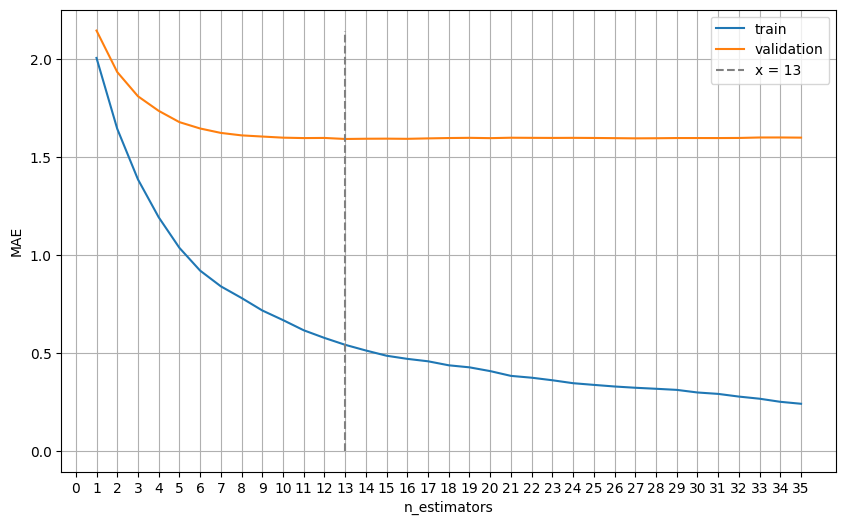

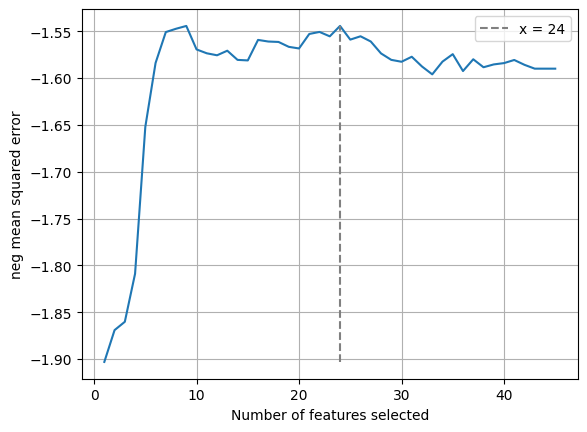

max_depth:  10
Number of estimators:  13
Selected_features:  Index(['acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'SLOPE_mean_1km',
       'ASPECT_mean_200m', 'ELEVATION_mean_1km', 'HILLSHADE_mean_1km',
       'FS_AREA_1km', 'FLOW_ACCU_200m', 'landcover', 'null_island_distance',
       'days_distance', 'mo_cos', 'year', 'lst', 'summer_days_month'],
      dtype='object')
prediction
0.0     287
1.0    1014
2.0    1343
3.0    1372
4.0     649
5.0     260
6.0      48
7.0      16
Name: count, dtype: int64

Low risk category stations: 1301
Medium risk category stations: 3624
High risk category stations: 64


In [8]:
#=====================================================================
# Automation models without or with/without entomological data
#=====================================================================

# Spit to train and test based on date of predictions
test = data.loc[data[date_col] >= pd.to_datetime(date)]
data = data.loc[data[date_col] < pd.to_datetime(date)]

# Delete from test set stations that are not used during the last 3 years
# test = unused_stations(data, test, period=3)

#Remove features that are more 40% filled with nan values in the test set
data, test = remove_nan_features(data, test, 0.3)

# set the only_env as True if there are no mosquitoes for the forecast month
only_env=None    
if len(test.dropna(subset=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks','previous_mosq_measure']).drop(columns=['mosq_now']).dropna())>0:
    only_env=False
elif len(test.drop(columns=['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                           'mosq_sum_previous_2weeks', 'previous_mosq_measure', 'mosq_now']).dropna())>0:
    only_env=True
else:
    print('No data left for prediction')

learning_rate = 0.3
# set the early stop argument as early_stop = (tolerance, min_delta)
early_stop = None
#set the transformation actions on the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the boolean for plotting feature importance (!very time consuming!)
fi = False
    
if only_env != None:
    # Run first without entomological features
    print("#===========================================")
    print("Predictions without entomological features")
    print("#===========================================")
    print()
    data_env = data.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    test_env = test.drop(['mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
                          'mosq_sum_previous_2weeks', 'previous_mosq_measure'], axis = 1)
    
    data_env = data_env.dropna().reset_index(drop=True)
    test_env = test_env.dropna(subset=test_env.columns.difference(['mosq_now'])).reset_index(drop=True)

    model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                          embedding_data = embedded_data,  transformation_list = transformation_list,
                          early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
    evaluate_xgboost(model, data_env, fi = fi)

    predictions_env = give_predictions_xgboost(model, data_env, test_env, env = True, filepath = path, case = title,
                                               fi = fi, export = only_env)


    # Run with entomological features if at least one station has mosquitos number
    if not only_env:
        print("#===========================================")
        print("Predictions with entomological features")
        print("#===========================================")
        print()
        
        data_entom = data.dropna().reset_index(drop=True)
        test_entom = test.dropna(subset=test.columns.difference(['mosq_now'])).reset_index(drop=True)
        
        model = Xgboost_model(model_type = model_type, learning_rate = learning_rate,
                              embedding_data = embedded_data,  transformation_list = transformation_list,
                              early_stop = False, l1_weight = 0, l2_weight = 0, weights = False)
    
        evaluate_xgboost(model, data_entom, fi = fi)

        predictions_entom = give_predictions_xgboost(model, data_entom, test_entom, env = True, filepath = path,
                                                     fi = fi, case = title, export = only_env)

        print("#===========================================")
        print("Predictions with/without entomological features")
        print("#===========================================")
        merge_predictions(predictions_env,predictions_entom, path, title, export=True)